In [26]:
import pandas as pd
import collections.abc
collections.Sequence = collections.abc.Sequence
collections.Iterable = collections.abc.Iterable
import hazm
import matplotlib.pyplot as plt
import math

SALAMAT = 'سلامت'
SIASI = 'سیاسی'
VARZESHI = 'ورزشی'
FANAVARI = 'فناوری'
HAVADES = 'حوادث'
FARHANGI_HONARI = 'فرهنگی/هنری'

<div dir="rtl">
<p>هدف از این پروژه تجزیه و دسته بندی اخبارهای یک سایت خبری میباشد و قصد داریم با استفاده از توضیحات هر خبر، آن را دسته بندی کنیم. در ابتدا به نرمالایز کردن داده ها می‌پردازیم و سپس سراغ حذف ایست واژه ها و کاراکتر های بی اهمیت می‌رویم. در نهایت با استفاده از معیار های مختلف به بررسی عملکرد توابع خود می‌پردازیم.</p>
<p>در مرحله اول دو فایل csv داده شده را میخوانیم و سپس آنهارا نرمالایز میکنیم.</p>
</div>

In [27]:
train_data = pd.read_csv('train.csv')
print(train_data.head())
test_data = pd.read_csv('test.csv')
print(test_data.head())

    label                                            content
0  فناوری  گزارش های منتشر شده حاکی از آن است که کاربران ...
1   ورزشی  سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2   حوادث  مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3  فناوری  یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4   سلامت  دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
         label                                            content
0       فناوری  بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...
1  فرهنگی/هنری  یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...
2        حوادث  آتش سوزی های زنجیره ای جنگل های زاگرس در استان...
3       فناوری  استفاده از سرویس‌های iMassage یا Facetime محصو...
4        حوادث  دادستان عمومی و انقلاب یاسوج گفت: 10 میلیون دل...


<div dir="rtl">
<h1>فاز اول: پیش پردازش داده</h1>
<p>در این بخش از کتابخانه هضم استفاده شده است. عملیات نرمالایز کردن در بخش content انجام گرفته است. در این قسمت به حذف کاراکتر های بی اهمیت مثل علامت سوال، نقطه و ... نیز پرداخته شده است. همچنین به حذف ایست واژه ها پرداختیم و با استفاده از تابع نرمالایز، فاصله بین کلمات را به نیم فاصله تبدیل کردیم تا مقایسه راحتتر صورت بگیرد.</p>
<p> سوال یک:</p>
<p>stemming: این روش سرعت بالا و دقت به نسبت کمی دارد. طرز کار آن این است که هر کلمه را به صورت مستقل میخواند و آن را به نزدیک ترین کلمه مبنای آن تبدیل میکند. ولی این روش ایراداتی نیز دارد به عنوان مثال کلمه را از فعل تفکیک نمیکند و این کار را با مشکل مواجه میسازد مثلا کلمه نسیم با استفاده از stemming، نس میشود.</p>
<p>lemmatization: این روش نسبت به روش قبلی دقت بالاتر و سرعت کمتری دارد. طرز کار این روش این است که هر کلمه را مستقل در نظر نمیگیرد بلکه پاره ای از کلمات را در نظر میگیرد و سپس بر اساس آن تصمیم میگیرد چه کلمه مبنایی را انتخاب کند. </p>
</div>

In [28]:
def useless_characters(words):
    newlist = []
    newlist = [x for x in words if x not in [' ','"','.', '\t', '...', '___', '«', '»', '،', '؛', '\n', '\u200c',')','(']]
    return newlist

def delete_stop_words(words):
    stopWords = set(hazm.stopwords_list("stopwords.txt"))
    stop_words = []
    counter = 0
    for i in range(len(words)):
        if words[i] in stopWords:
            stop_words.append(i)
    for i in range(len(stop_words)):
        words.remove(words[stop_words[i] - counter])
        counter += 1
    return words

In [29]:
def normalize(data):
    new_content = {FANAVARI: [], VARZESHI: [], HAVADES: [], SALAMAT: [], SIASI: [], FARHANGI_HONARI: []}
    contents = data['content']
    words = []
    normalizer = hazm.Normalizer()
    for i in range(len(contents)):
        contents[i] = normalizer.normalize(contents[i])
        words = hazm.word_tokenize(contents[i])
        words = delete_stop_words(words)
        words = useless_characters(words)
        #words = [lemmatizer.lemmatize(word) for word in words]
        new_content[data['label'][i]].append(words)
    return new_content

In [30]:
train_normalized = normalize(train_data)
test_normalized = normalize(test_data)

In [31]:
def pre_process(all_labels, all_words, train_normalized):
    for label in train_normalized:
        for content in train_normalized[label]:
            for word in content:
                if word not in all_words[label]:
                    all_words[label][word] = 1
                else:
                    all_words[label][word] += 1
                all_labels[label] += 1
    return all_labels, all_words

In [32]:
labels = train_data['label']
all_labels = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
all_words = {SALAMAT:{},SIASI:{},VARZESHI:{},FANAVARI:{},HAVADES:{},FARHANGI_HONARI:{}}
all_labels, all_words = pre_process(all_labels,all_words, train_normalized)
all_count = all_labels[SALAMAT] + all_labels[SIASI] + all_labels[VARZESHI] + all_labels[FANAVARI] + all_labels[HAVADES] + all_labels[FARHANGI_HONARI]
print(all_labels)
print(all_count)

{'سلامت': 401770, 'سیاسی': 357382, 'ورزشی': 218580, 'فناوری': 322069, 'حوادث': 166083, 'فرهنگی/هنری': 318486}
1784370


<div dir="rtl">
<h1>فاز دوم: فرآیند مسئله</h1>
<p>در این بخش دو تابع naive_bayes و smooth_naive_bayes پیاده سازی شده است. در اینجا طبق قانون بیز که در پایین آمده است عمل کردیم. حال به بررسی هر یک از آن میپردازیم.</p>
<p>سوال دو:</p>
<p>posterior: این بدان معنیست که اگر کلمه x را داریم، با چه احتمالی در دسته بندی c قرار دارد. -> p(c|x)</p>
<p>prior: یعنی احتمال اینکه در این دسته بندی باشیم نسبت به اینکه در دسته بندی های دیگر باشیم، چقدر است -> p(c)</p>

$$ p(c)=\frac{تعداد\:دفعاتی\:که\:کلمه\:c\:ظاهر\:شده\:است}{اندازه\:دیتا}$$

<p>likelihood: یعنی اگر در دسته بندی c قرار داشته باشیم، چقدر احتمال دارد که کلمه x وجود داشته باشد. -> p(x|c)</p>

$$ p(x|c)=\frac{تعداد\:دفعاتی\:که\:کلمه\:x\:در\:کلاس\:c\:ظاهر\:شده\:است}{تمام\:کلمات\:کلاس\:c}$$

<p>evidence: یعنی احتمال اینکه کلمه مورد نظر بین همه کلمه ها انتخاب شود چقدر است -> p(x)</p>

$$ p(x)=\frac{تعداد\:دفعاتی\:که\:کلمه\:x\:ظاهر\:شده\:است}{تعداد\:کل\:کلمات}$$

</div>

$$ p(c|x)=\frac{p(x|c)p(c)}{p(x)}$$

<div dir="rtl">
<h2>Bigrams</h2>
<p>سوال سه:</p>
<p>1- آن دختر موی سرش را شانه میکند.</p>
<p>2- شانه‌ی حمید درد می کند.</p>
<p>در دو جمله ی بالا، شانه در دو معنی مختلف به کار رفته است.اگر به معنی آنها توجه نشود، همگی در یک گروه قرار میگیرند در حالیکه معنی های آنها با یکدیگر سازگار نیست. استفاده از bigram باعث بروز همچین مشکلاتی نمیشود و دقت ما را در انجام محاسبات بالاتر میبرد.</p>
</div>

In [33]:
def naive_bayes(data, all_labels, all_words, all_count, label):
    prob = math.log(all_labels[label]/all_count)
    for word in data:
        if word in all_words[label]:
            prob += math.log(all_words[label][word]/all_labels[label])
        else:
            return 0
    return -prob

def smooth_naive_bayes(data, all_labels, all_words, all_count, label):
    prob = math.log(all_labels[label]/all_count)
    for word in data:
        if word in all_words[label]:
            prob += math.log((all_words[label][word] + 1)/(all_labels[label] + len(all_words[label])))
        else:
            prob += math.log(1/(all_labels[label] + len(all_words[label])))
    return prob

<div dir="rtl">
<p>سوال چهار:</p>
<p>در اینجا ما کلمات را مستقل از یکدیگر در نظر میگیریم و این احتمالات را در هم ضرب میکنیم. اگر یکی از این احتمالات صفر باشد، کل جواب صفر خواهد شد که این مطلوب ما نیست. زیرا اگر یک کلمه در جمله وجود داشته باشد که در دسته بندی کلمات نباشد، هرچند احتمال بقیه کلمات بالا باشد، باز هم جواب در نهایت صفر میشود. یک مشکل دیگر این است که ممکن است کلمه فقط در یک گروه باشد ولی ربطی به داده اصلی ما نداشته باشد، در اینصورت احتمال ما میگوید حتما در این دسته بندی قرار دارد. اشکال دیگر نیز میتواند این باشد که کلمه مورد نظر در هیچکدام از دسته بندی ها وجود نداشته باشد در اینصورت احتمال ما نمیتواند تصمیم بگیرد که مربوط به کدام دسته بندی  است.</p>
<p>سوال پنج: </p>
<p>همانطور که در فرمول استفاده شده در تابع smooth مشخص است، هم صورت و هم مخرج با عدد یک جمع شده است. این برای از بین بردن مشکل گفته شده در سوال قبل میباشد. در اینصورت اگر کلمه در دسته بندی کلمات نباشد، دیگر احتمال صفر نمیشود و این ما را به جواب درست تری میرساند.</p>
</div>

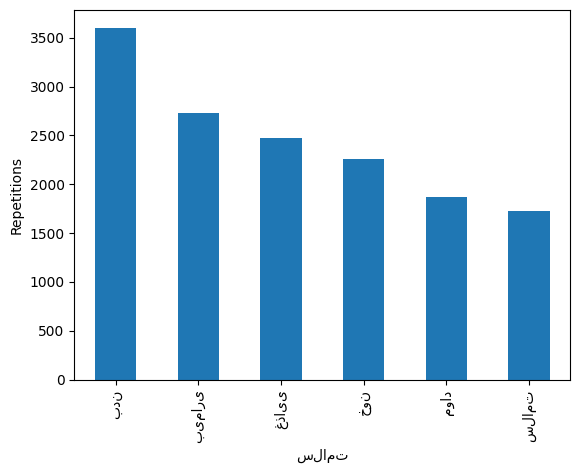

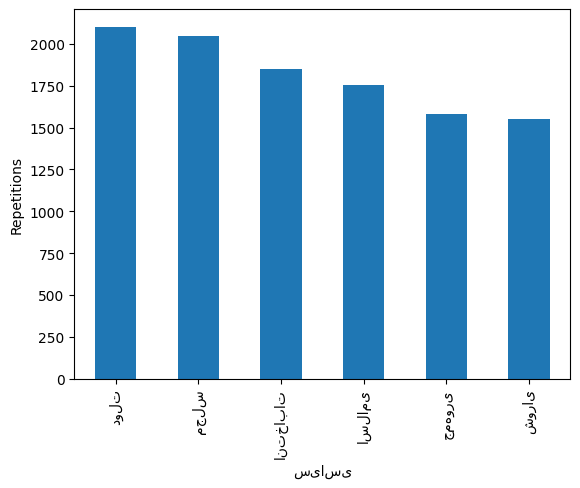

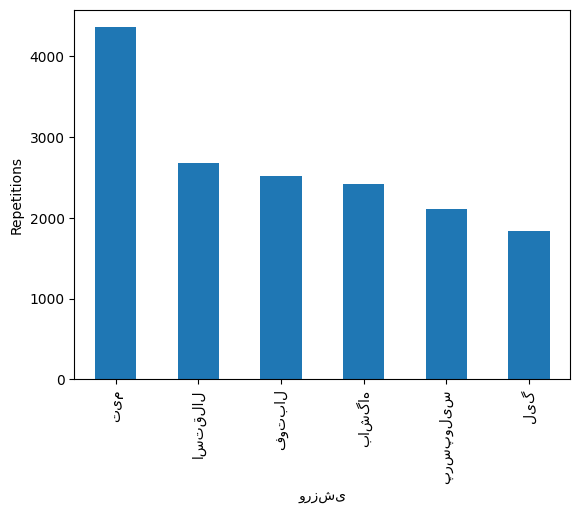

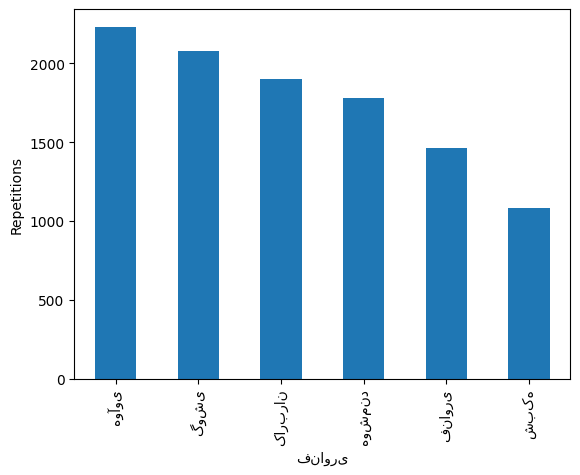

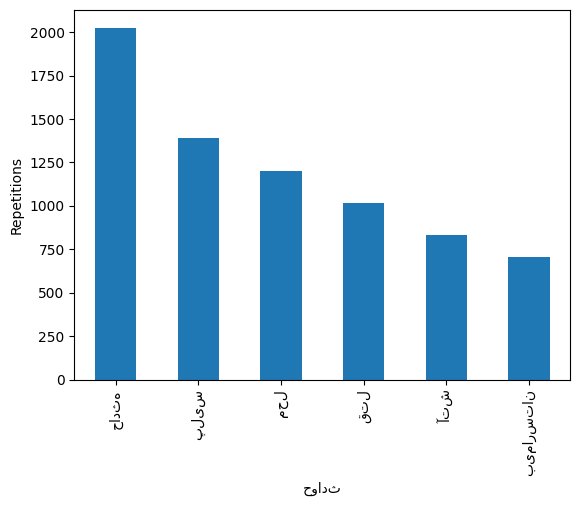

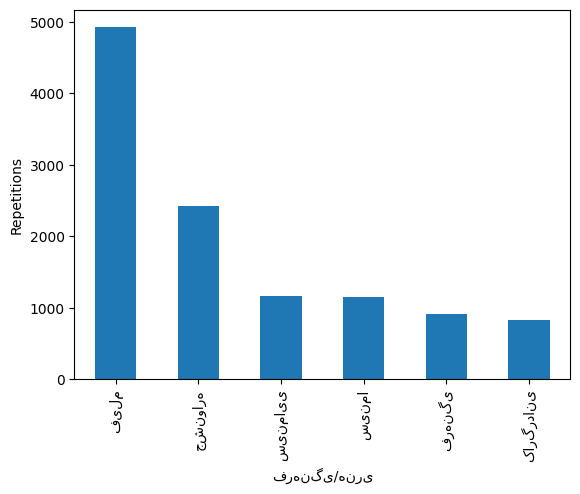

In [34]:
ploting = pd.DataFrame(all_words)
for label in all_words:
    data=ploting.nlargest(6, [label])
    plt.xlabel(label)
    plt.ylabel("Repetitions")
    data[label].plot.bar()
    plt.show()

<div dir="rtl">
<h1>بررسی صحت</h1>
<p>سوال شش:</p>
<p>در قسمت بالا 6 کلمه که در هر دسته بیشترین تکرار را دارند، نشان داده شده است. برای حذف کلمات غیر مرتبط، کلماتی را به ایست واژه اضافه کردم تا دقت بالاتر رود. همانطور که در شکل زیر مشخص است، 6 کلمه که در هر دسته بندی بیشترین تکرار را دارد به شرح زیر میباشد.</p>
<h3>سلامت</h3>
<p>بدن، بیماری، غذایی، خون، مواد، سلامت</p>
<h3>فناوری</h3>
<p>هوآوی، گوشی، کاربران، هوشمند، فناوری، شبکه</p>
<h3>فرهنگی و هنری</h3>
<p>فیلم، جشنواره، سینمایی، سینما، فرهنگی، کارگردانی</p>
<h3>سیاسی</h3>
<p>دولت، مجلس، انتخابات، اسلامی، جمهوری، شورای</p>
<h3>ورزشی</h3>
<p>تیم، استقلال، فوتبال، باشگاه، پرسپولیس، لیگ</p>
<h3>حوادث</h3>
<p>حادثه، پلیس، محل، قتل، آتش، بیمارستان</p>
</div>

In [43]:
label_list = [SALAMAT,SIASI,VARZESHI,FANAVARI,HAVADES,FARHANGI_HONARI]
correctDetected = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
allDetected = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
classTotal = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
precision = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
recall = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
F1 = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}

<div dir="rtl">
<h1>فاز سوم: ارزیابی</h1>
</div>

$$ Accuracy=\frac{Correct Detected}{Total}$$

$$ Precision=\frac{Correct Detected Class}{All Detected Class(Includin Wrong Ones)}$$

$$ Recall=\frac{Correct DetectedClass}{TotalClass}$$

$$ F1= 2*\frac{Precision*Recall}{Precision+Recall}$$

<div dir="rtl">
<p>سوال هفت:</p>
<p>معیار precision در واقع به ما میگوید الگوریتم ما چند درصد بله هایش درست است. به عنوان مثال میتوانیم فرض کنیم تشخیص تومور برای فردی داده شده است. این تشخیص میتواند غلط باشد و فرد در هر صورت استرس زیادی میگیرد و باید پول زیادی برای درمان خرج کند و اگر تشخیص بیماری اشتباه باشد، ضرر زیادی متحمل میشود. معیار recall به دنبال پوشش به روی کل داده هاست و تمرکز آن به روی داده هاییست که واقعا بله بودند. به عنوان مثال میتوانیم فرض کنیم تشخیص بیماری واگیردار را محاسبه میکنیم. اگر فقط از این روش استفاده کنیم و مقدار recall پایین باشد، خطرناک است زیرا افراد زیادی را به عنوان سالم در نظر میگیریم و این میتواند فاجعه درست کند پس هریک از آنها به تنهایی برای ارزیابی مدل کافی نیست.</p>
<p>سوال هشت:</p>
<p>معیار F1 در واقع ترکیبی از recall و precision میباشد که در واقع به آن harmonic mean نیز میگویند. harmonic mean صحیح ترین میانگین را به ما میدهد .در میانگین گیری عادی جمع همه اعداد را بر تعداد کل تقسیم میکردیم ولی در اینجا به این صورت عمل میکنیم که ابتدا عدد یک را بر تمامی مشاهدات تقسیم و سپس انهارا با یکدیگر جمع میکنیم. این کار اثر داده های خیلی بزرگ را کمی پایینتر و داده های بسیار پایین را کمی بالاتر می اورد.</p>
<p>اهمیت آن نیز به این علت است که ما میخواهیم یک معیار منطقی از میانگین recall و precision داشته باشیم که میانگین هارمونیک بهترین گزینه میباشد.</p>
<p>سوال نه:</p>
<p>macro : درواقع همان میانگین گیری عادی میباشد یعنی ابتدا تک تک مقادیر را جمع کرده و سپس بر تعدادشان تقسیم میکنیم.</p>
<p>micro : درواقع تقسیم true positive ها بر flase positive + true postive میباشد. یعنی درواقع پیشبینی های درست را بر کل پیشبینی ها تقسیم میکنیم. در اینجا مقدار آن با accuracy برابر است.</p>
<p>weighted : در این قسمت از میانگین وزن دار کمک میگیریم. یعنی جمع هر گروه در سهمش را بدست میاوریم و تقسیم بر تعداد سهم ها میکنیم.</p>
</div>

In [45]:
#making table
col = ['Health','Political','Sports','Technology','Art','Accidents','All Classes']
rows = ['Precision','Recall','F1-score','Accuracy','Macro Average','Micro Average','Weighted Average']
final_table = pd.DataFrame(index = rows, columns=col)
#testing with naive bayse
for key in test_normalized.keys():
    for i in range(len(test_normalized[key])):
        max_prob = 0
        category = ""
        for label in label_list:
            prob = naive_bayes(test_normalized[key][i], all_labels, all_words, all_count, label)
            if prob > max_prob:
                max_prob = prob
                category = label
        if category == key:
            correctDetected[category] += 1
        if category != "":
            allDetected[category] += 1
        classTotal[key] += 1
totalClass = 0
for key in classTotal.keys():   
    totalClass += classTotal[key]
Accuracy = correctDetected[SALAMAT] + correctDetected[SIASI] + correctDetected[VARZESHI] + correctDetected[FANAVARI] + correctDetected[HAVADES] + correctDetected[FARHANGI_HONARI]
Accuracy = Accuracy / totalClass
final_table['All Classes']['Accuracy'] = Accuracy

#calculating precision, recall and F1-score
for key in classTotal.keys():
    precision[key] = correctDetected[key]/allDetected[key]
    recall[key] = correctDetected[key]/classTotal[key]
    F1[key] = 2 * precision[key] * recall[key] / (precision[key] + recall[key])
    if key == SALAMAT:
        final_table['Health']['Precision'] = precision[key]
        final_table['Health']['Recall'] = recall[key]
        final_table['Health']['F1-score'] = F1[key]
    elif key == SIASI:
        final_table['Political']['Precision'] = precision[key]
        final_table['Political']['Recall'] = recall[key]
        final_table['Political']['F1-score'] = F1[key]
    elif key == VARZESHI:
        final_table['Sports']['Precision'] = precision[key]
        final_table['Sports']['Recall'] = recall[key]
        final_table['Sports']['F1-score'] = F1[key]
    elif key == FANAVARI:
        final_table['Technology']['Precision'] = precision[key]
        final_table['Technology']['Recall'] = recall[key]
        final_table['Technology']['F1-score'] = F1[key]
    elif key == HAVADES:
        final_table['Accidents']['Precision'] = precision[key]
        final_table['Accidents']['Recall'] = recall[key]
        final_table['Accidents']['F1-score'] = F1[key]
    elif key == FARHANGI_HONARI:
        final_table['Art']['Precision'] = precision[key]
        final_table['Art']['Recall'] = recall[key]
        final_table['Art']['F1-score'] = F1[key]
#calculating macro average
Macro_F1 = 0
for key in F1.keys():
    F1[key] = 2*precision[key] * recall[key] / (precision[key] + recall[key])
    Macro_F1 += F1[key]
Macro_F1 = Macro_F1 / 6
final_table['All Classes']['Macro Average'] = Macro_F1

#calculating weighted average
Weighted_F1 = 0
total = 0
for key in F1.keys():
    Weighted_F1 += F1[key] * classTotal[key]
    total += classTotal[key]
Weighted_F1 = Weighted_F1 / total
final_table['All Classes']['Weighted Average'] = Weighted_F1
    
#calculating micro average
micro_average = Accuracy
final_table['All Classes']['Micro Average'] = micro_average
final_table

,Health,Political,Sports,Technology,Art,Accidents,All Classes
Precision,0.48,0.586207,0.641026,0.352941,0.396226,0.833333,NaN
Recall,0.067797,0.085,0.131579,0.035714,0.116667,0.075,NaN
F1-score,0.118812,0.148472,0.218341,0.064865,0.180258,0.137615,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.086099
Macro Average,NaN,NaN,NaN,NaN,NaN,NaN,0.144727
Micro Average,NaN,NaN,NaN,NaN,NaN,NaN,0.086099
Weighted Average,NaN,NaN,NaN,NaN,NaN,NaN,0.146256


In [47]:
label_list = [SALAMAT,SIASI,VARZESHI,FANAVARI,HAVADES,FARHANGI_HONARI]
correctDetected = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
allDetected = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
classTotal = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
precision = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
recall = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}
F1 = {SALAMAT:0,SIASI:0,VARZESHI:0,FANAVARI:0,HAVADES:0,FARHANGI_HONARI:0}

In [48]:
#making table
col = ['Health','Political','Sports','Technology','Art','Accidents','All Classes']
rows = ['Precision','Recall','F1-score','Accuracy','Macro Average','Micro Average','Weighted Average']
final_table = pd.DataFrame(index = rows, columns=col)
#testing with smooth naive bayse
for key in test_normalized.keys():
    for i in range(len(test_normalized[key])):
        max_prob = 0
        category = ""
        for label in label_list:
            prob = smooth_naive_bayes(test_normalized[key][i], all_labels, all_words, all_count, label)
            if prob > max_prob or max_prob == 0:
                max_prob = prob
                category = label
        if category == key:
            correctDetected[category] += 1
        if category != "":
            allDetected[category] += 1
        classTotal[key] += 1
totalClass = 0
for key in classTotal.keys():   
    totalClass += classTotal[key]
Accuracy = correctDetected[SALAMAT] + correctDetected[SIASI] + correctDetected[VARZESHI] + correctDetected[FANAVARI] + correctDetected[HAVADES] + correctDetected[FARHANGI_HONARI]
Accuracy = Accuracy / totalClass
final_table['All Classes']['Accuracy'] = Accuracy

#calculating precision, recall and F1-score
for key in classTotal.keys():
    precision[key] = correctDetected[key]/allDetected[key]
    recall[key] = correctDetected[key]/classTotal[key]
    F1[key] = 2 * precision[key] * recall[key] / (precision[key] + recall[key])
    if key == SALAMAT:
        final_table['Health']['Precision'] = precision[key]
        final_table['Health']['Recall'] = recall[key]
        final_table['Health']['F1-score'] = F1[key]
    elif key == SIASI:
        final_table['Political']['Precision'] = precision[key]
        final_table['Political']['Recall'] = recall[key]
        final_table['Political']['F1-score'] = F1[key]
    elif key == VARZESHI:
        final_table['Sports']['Precision'] = precision[key]
        final_table['Sports']['Recall'] = recall[key]
        final_table['Sports']['F1-score'] = F1[key]
    elif key == FANAVARI:
        final_table['Technology']['Precision'] = precision[key]
        final_table['Technology']['Recall'] = recall[key]
        final_table['Technology']['F1-score'] = F1[key]
    elif key == HAVADES:
        final_table['Accidents']['Precision'] = precision[key]
        final_table['Accidents']['Recall'] = recall[key]
        final_table['Accidents']['F1-score'] = F1[key]
    elif key == FARHANGI_HONARI:
        final_table['Art']['Precision'] = precision[key]
        final_table['Art']['Recall'] = recall[key]
        final_table['Art']['F1-score'] = F1[key]

#calculating macro average
Macro_F1 = 0
for key in F1.keys():
    F1[key] = 2*precision[key] * recall[key] / (precision[key] + recall[key])
    Macro_F1 += F1[key]
Macro_F1 = Macro_F1 / 6
final_table['All Classes']['Macro Average'] = Macro_F1

#calculating weighted average
Weighted_F1 = 0
total = 0
for key in F1.keys():
    Weighted_F1 += F1[key] * classTotal[key]
    total += classTotal[key]
Weighted_F1 = Weighted_F1 / total
final_table['All Classes']['Weighted Average'] = Weighted_F1
    
#calculating micro average
micro_average = Accuracy
final_table['All Classes']['Micro Average'] = micro_average
final_table


,Health,Political,Sports,Technology,Art,Accidents,All Classes
Precision,0.97093,0.876712,0.983957,0.969136,0.968944,0.906542,NaN
Recall,0.943503,0.96,0.968421,0.934524,0.866667,0.97,NaN
F1-score,0.95702,0.916468,0.976127,0.951515,0.914956,0.937198,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.941704
Macro Average,NaN,NaN,NaN,NaN,NaN,NaN,0.942214
Micro Average,NaN,NaN,NaN,NaN,NaN,NaN,0.941704
Weighted Average,NaN,NaN,NaN,NaN,NaN,NaN,0.941826


<div dir="rtl">
<p>سوال یازده: </p>
<p>با مقایسه accuracy میفهمیم smoothing بسیار بهتر از حالت اول عمل میکند و مدل مناسبتری برای محاسبه داده ها میباشد. و همچنین مشکلاتی که در حالت عادی بیز اینجاد میشد(مانند صفر شدن به علت وجود نداشتن یک کلمه) دیگر در اینجا رخ نمیدهد.</p>
<p>سوال دوازده: </p>
<p>کد زیر برای نشان دادن 5 مورد اشتباه نوشته شده است. همانطور که در نتیجه پیداست،کتگوری بعضی کلمات به اشتباه انتخاب شده است. از دلایل بروز این اتفاق میتوان به این اشاره کرد که کلمه های کلی و بی معنی حذف نشده اند به عنوان مثال در نمونه پایین یکی از کلمه هایی اشتباه تشخیص داده شده، شایسته است میباشد و طبیعتا از روی این کلمه نمیتوان مشخص کرد که مربوط به کدام بخش است پس امکان اشتباه وجود دارد. مشکل دیگر میتواند این باشد که یک کلمه در چند کلاس قرار گرفته باشد و اینگونه تشخیص اینکه دقیقا به کدام کلاس تعلق دارد سختتر میشود که راه حل این مشکل نیز بالا بردن دقت در حذف کلمات است.</p>
</div>

In [39]:
label_list = [SALAMAT,SIASI,VARZESHI,FANAVARI,HAVADES,FARHANGI_HONARI]
count = 0
for key in test_normalized.keys():
    count += 1
    repeated = False
    for i in range(len(test_normalized[key])):
        max_prob = 0
        for label in label_list:
            prob = naive_bayes(test_normalized[key][i], all_labels, all_words, all_count, label)
            if prob > max_prob:
                max_prob = prob
                category = label
        if category != key and count < 7 and repeated == False:
            repeated = True
            print("wrong detected: ", test_normalized[key][0][0], "Wrong category: ", category, "Correct category: ", key)

wrong detected:  لیست Wrong category:  سیاسی Correct category:  فناوری
wrong detected:  شایسته_است Wrong category:  فرهنگی/هنری Correct category:  ورزشی
wrong detected:  آتش Wrong category:  ورزشی Correct category:  حوادث
wrong detected:  خطرناک‌ترین Wrong category:  فناوری Correct category:  سلامت
wrong detected:  رییس Wrong category:  سلامت Correct category:  سیاسی
wrong detected:  استاد Wrong category:  فناوری Correct category:  فرهنگی/هنری
